# RoBERTa fine-tuning


## Imports

In [1]:
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer
import torch

from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from scipy.special import softmax

import yaml

# Local imports
from model import RoBERTaClassification
from data import read_data
from utils import get_report

%matplotlib inline

In [2]:
with open("config.yml") as f:
    params = yaml.load(f, Loader=yaml.FullLoader)

## Dataset import
The following steps are done in `generate_data.py`:
* Load [dataset](https://huggingface.co/datasets/tweets_hate_speech_detection)
* Split dataset into `train` / `validation` / `test` (60/20/20)
* Save data into files

In [3]:
# You can uncomment this line to re-generate data files
# !python generate_data.py

In [3]:
# Load splitted dataset
train_data = pd.read_csv(Path(params["data"]["path_to_data"]) / params["data"]["train_filename"])
valid_data = pd.read_csv(Path(params["data"]["path_to_data"]) / params["data"]["validation_filename"])
test_data = pd.read_csv(Path(params["data"]["path_to_data"]) / params["data"]["test_filename"])

# Basic information
print(f'Shapes (train/val/test): {train_data.shape[0]}/{valid_data.shape[0]}/{test_data.shape[0]}')
test_data.head()

Shapes (train/val/test): 19177/6393/6392


,label,tweet
0,1,sea shepherd suppoers are racist! #antiracis...
1,0,happy is doesn't mean forever because there's ...
2,0,finally a cooler breezy day! i'm so !
3,0,i helped someone work thru a paicularly tricky...
4,0,i am enchanting. #i_am #positive #affirmation ...


## EDA
Summary:

* Имеется дизбаланс классов: 29753 / 2209 (0 - 93%/ 1 - 7%)
* Длина твитов с `hate speech` и без него имеют одинаковое распределение

In [4]:
# Generate general dataset for EDA
data = pd.concat([train_data, valid_data, test_data])

print(data.shape)
data.head()

(31962, 2)


,label,tweet
0,0,some of our lovely clients happy with their tr...
1,0,be n #healthy how many cares one loses when ...
2,0,so so #young #ripchristina
3,0,~just enjoying life. ð
4,0,i am thankful for my friends. #thankful #posit...


Classes balance:
0 class: 29720 samples (0.93)
1 class: 2242  samples (0.07)

Length information:


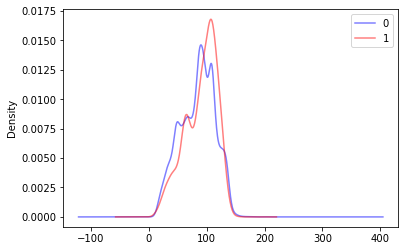

In [5]:
neg_class_count = data['label'].tolist().count(0)
pos_class_count = data['label'].tolist().count(1)
total_count = data.shape[0]

print('Classes balance:')
print(f'0 class: {neg_class_count} samples ({round(neg_class_count/total_count, 2)})')
print(f'1 class: {pos_class_count}  samples ({round(pos_class_count/total_count, 2)})\n')

print('Length information:')
data.query('label == 0')['tweet'].apply(len).plot.kde(color='b', alpha=0.5, label='0')
data.query('label == 1')['tweet'].apply(len).plot.kde(color='r', alpha=0.5, label='1')

plt.legend()
plt.show()

## Before fine-tuning

In [7]:
# Load model for zero-shot-classification
from transformers import pipeline
classifier = pipeline('zero-shot-classification')

Some weights of the model checkpoint at facebook/bart-large-mnli were not used when initializing BartModel: ['model.encoder.version', 'model.decoder.version']
- This IS expected if you are initializing BartModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at facebook/bart-large-mnli were not used when initializing BartForSequenceClassification: ['model.encoder.version', 'model.decoder.version']
- This IS expected if you are initializing BartForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification m

In [8]:
sequences = test_data['tweet'].values.tolist()
labels = ['sexism', 'racism', 'hate speech']
batch_size = 1
zero_shot_predictions = []

for idx in tqdm(range(len(sequences))):
    res = classifier(sequences[idx], labels, multi_label=True)
    
    output = {}
    for label, score in zip(res['labels'], res['scores']):
        output[label] = score
    zero_shot_predictions.append(output)

In [9]:
with open(params["data"]["path_to_test_zero_shot"], 'w') as fout:
    json.dump(zero_shot_predictions, fout)

## Training

In [6]:
from pathlib import Path

import numpy as np
import torch
import yaml
from catalyst.dl import SupervisedRunner
from catalyst.dl.callbacks import (
    AccuracyCallback,
    CheckpointCallback,
    InferCallback,
    OptimizerCallback,
)
from catalyst.utils import prepare_cudnn, set_global_seed

In [7]:
# read and process data
train_val_loaders, test_loaders = read_data(params)

# initialize the model
model = RoBERTaClassification(
    pretrained_model_name=params["model"]["model_name"],
    num_classes=params["model"]["num_classes"]
)

# specify criterion for the multi-class classification task, optimizer and scheduler
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=float(params["training"]["learn_rate"])
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

# reproducibility
set_global_seed(params["general"]["seed"])
# prepare_cudnn(deterministic=True)

# here we specify that we pass masks to the runner. So model's forward method will be called with
# these arguments passed to it.
runner = SupervisedRunner(input_key=("features", "attention_mask"))

## Running training

In [8]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [9]:
# finally, training the model with Catalyst
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=train_val_loaders,
    callbacks=[
        AccuracyCallback(num_classes=int(params["model"]["num_classes"])),
        OptimizerCallback(accumulation_steps=int(params["training"]["accum_steps"])),
    ],
    logdir=params["training"]["log_dir"],
    num_epochs=int(params["training"]["num_epochs"]),
    verbose=True,
)

1/1 * Epoch (train): 100% 300/300 [1:03:39<00:00, 12.73s/it, accuracy01=0.976, loss=0.077]
1/1 * Epoch (valid): 100% 100/100 [07:05<00:00,  4.25s/it, accuracy01=0.965, loss=0.084]
[2021-04-03 22:41:00,994] 
1/1 * Epoch 1 (_base): lr=3.000e-05 | momentum=0.9000
1/1 * Epoch 1 (train): accuracy01=0.9332 | loss=0.1723
1/1 * Epoch 1 (valid): accuracy01=0.9661 | loss=0.0987
Top best models:
logdir/checkpoints/train.1.pth	0.0987


## Evaluation

In [10]:
# and running inference
torch.cuda.empty_cache()
runner.infer(
    model=model,
    loaders=test_loaders,
    callbacks=[
        CheckpointCallback(
            resume=f"{params['training']['log_dir']}/checkpoints/best.pth"
        ),
        InferCallback(),
    ],
    verbose=True,
)

# lastly, saving predicted scores for the test set
predicted_scores = runner.callbacks[0].predictions["logits"]
np.savetxt(X=predicted_scores, fname=params["data"]["path_to_test_finetuned"])

=> Loading checkpoint logdir/checkpoints/best.pth
loaded state checkpoint logdir/checkpoints/best.pth (global epoch 1, epoch 1, stage train)
1/1 * Epoch (test): 100% 100/100 [06:55<00:00,  4.15s/it]


## Metrics analysis

In [18]:
# retrieve labels from data loaders
true_predictions = test_data['label'].tolist()

Best Threshold: 0.4994 with F-Score: 0.4367
Recall: 0.5368, Precision: 0.3681

(With best threshold) Accuracy: 0.91, F1: 0.44


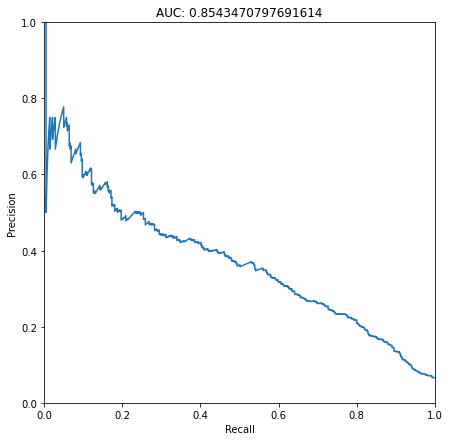

In [24]:
zero_shot_probs = [max(pred.values()) for pred in zero_shot_predictions]
zero_shot_rec, zero_shot_pr = get_report(true_predictions, zero_shot_probs)

Best Threshold: 0.29820001125335693 with F-Score: 0.7191
Recall: 0.7387, Precision: 0.7005

(With best threshold) Accuracy: 0.96, F1: 0.72


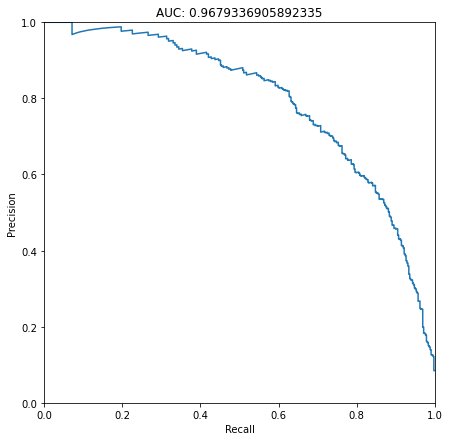

In [19]:
finetuned_probs = softmax(predicted_scores, axis=1)[:, 1]
finetuned_rec, finetuned_pr = get_report(true_predictions, finetuned_probs)

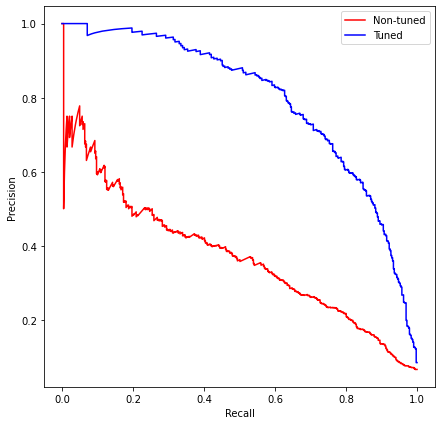

In [26]:
plt.figure(figsize=(7, 7))

plt.plot(zero_shot_rec, zero_shot_pr, c='r', label='Non-tuned')
plt.plot(finetuned_rec, finetuned_pr, c='b', label='Tuned')

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.legend()
plt.show()

## Conclusion
Как видно из сравнения метрик - `zero-shot-classification` показывает более низкое качество, нежели дообученная модель.